https://arxiv.org/pdf/2309.11400
https://arxiv.org/pdf/2411.05790

TLDR LSTM is good enough

In [1]:
import numpy as np
import torch
import random
import os

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(seed=420)

                       open   close    high     low     volume
2013-04-01 00:07:00   93.25   93.30   93.30   93.25  93.300000
2013-04-01 00:08:00  100.00  100.00  100.00  100.00  93.300000
2013-04-01 00:09:00   93.30   93.30   93.30   93.30  33.676862
2013-04-01 00:10:00   93.30   93.30   93.30   93.30   0.000000
2013-04-01 00:11:00   93.35   93.47   93.47   93.35  20.000000
                        open    close     high      low    volume
2023-10-08 09:24:00  27927.0  27927.0  27927.0  27927.0  0.000000
2023-10-08 09:25:00  27927.0  27927.0  27927.0  27927.0  0.000000
2023-10-08 09:26:00  27927.0  27927.0  27927.0  27927.0  0.000000
2023-10-08 09:27:00  27927.0  27927.0  27927.0  27927.0  0.000000
2023-10-08 09:28:00  27912.0  27912.0  27912.0  27912.0  0.000442


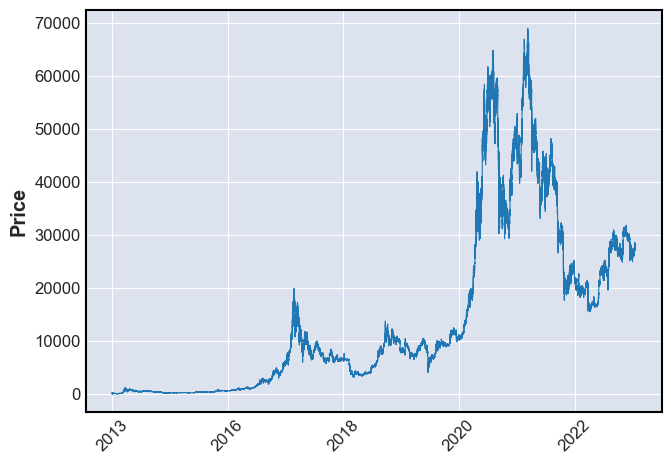

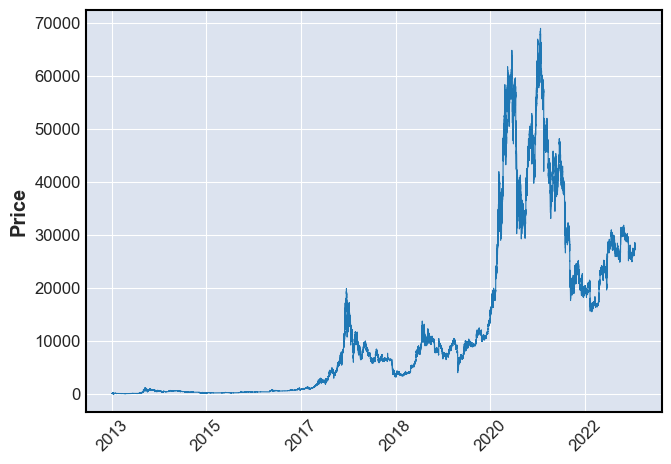

                       open   close    high     low    volume
2013-04-01 00:07:00   93.25   93.30   93.30   93.25  2.502149
2013-04-01 00:08:00  100.00  100.00  100.00  100.00  2.502149
2013-04-01 00:09:00   93.30   93.30   93.30   93.30  1.758977
2013-04-01 00:10:00   93.30   93.30   93.30   93.30 -0.875289
2013-04-01 00:11:00   93.35   93.47   93.47   93.35  1.386391 open      0.010000
close     1.060000
high      1.060000
low       0.010000
volume   -0.875289
dtype: float64 open      68925.000000
close     68925.000000
high      68958.000000
low       68734.000000
volume        5.725743
dtype: float64
(22132168,)
11.14126740407234 0.009950330853168092 8.135346188400915 1.9180121525920217
68925.0 68925.0 68958.0 68734.0


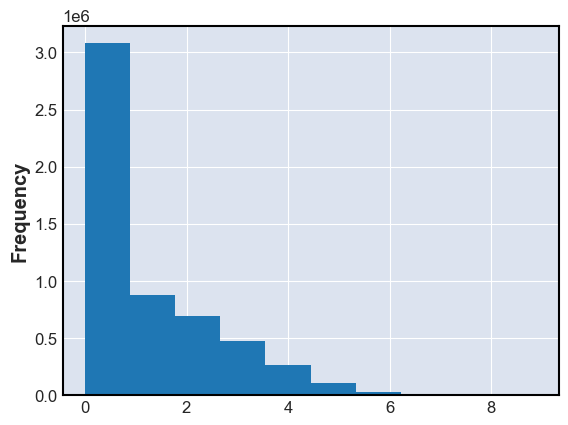

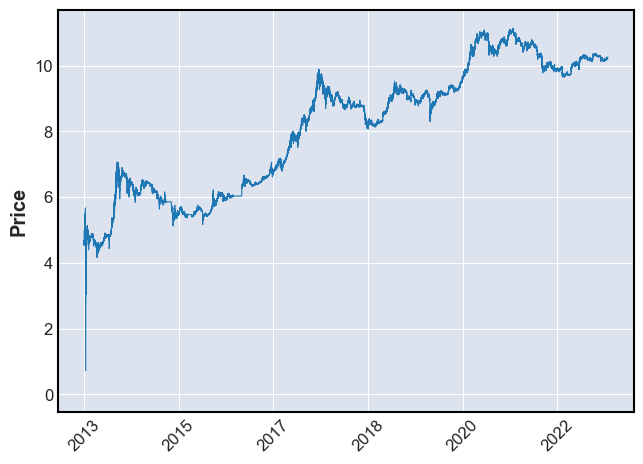

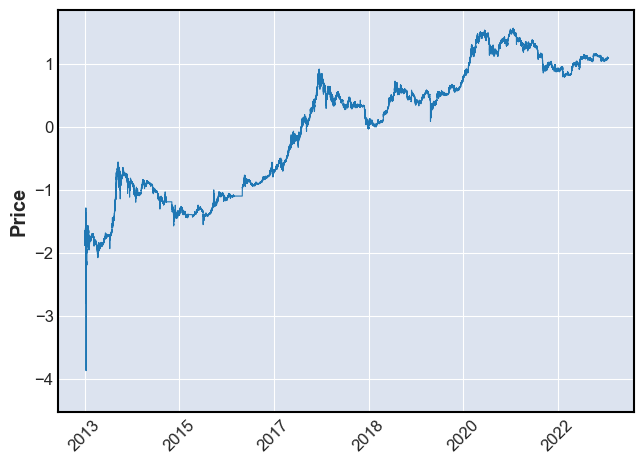

In [2]:
%run load_data.ipynb

In [3]:
from torch.utils.data import DataLoader, Dataset
import torch

# Convert DataFrame to numpy array
data = df_norm.values

# Create sequences and targets
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Parameters
seq_length = 64  # Length of each sequence

# Create sequences and targets
sequences, targets = create_sequences(data, seq_length)

# Sequential split
train_size = int(len(sequences) * 0.4)
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]

# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Create Datasets
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

batch_size = 64

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print(X_train[0])
print()
print(y_train[0])

print(len(sequences), len(targets))
print(len(train_dataset), len(test_dataset))
print(sequences.shape, targets.shape)

[[-1.87141273 -1.87113936 -1.87131296 -1.87123868  2.50214939]
 [-1.83534954 -1.83535263 -1.83552686 -1.83517486  2.50214939]
 [-1.87113621 -1.87113936 -1.87131296 -1.87096215  1.75897727]
 [-1.87113621 -1.87113936 -1.87131296 -1.87096215 -0.87528894]
 [-1.87085984 -1.87020029 -1.87037391 -1.87068578  1.38639133]
 [-1.87019715 -1.87020029 -1.87037391 -1.87002308 -0.05382818]
 [-1.87263109 -1.8726343  -1.87280782 -1.87245712  0.45394314]
 [-1.87263115 -1.8726343  -1.87280787 -1.87245712 -0.87528894]
 [-1.87263115 -1.8726343  -1.87280787 -1.87245712 -0.87528894]
 [-1.87263115 -1.8726343  -1.87280787 -1.87245712 -0.87528894]
 [-1.87263115 -1.8726343  -1.87280787 -1.87245712 -0.87528894]
 [-1.87263115 -1.8726343  -1.87280787 -1.87245712 -0.87528894]
 [-1.87263115 -1.8726343  -1.87280787 -1.87245712 -0.87528894]
 [-1.87263115 -1.8726343  -1.87280787 -1.87245712 -0.87528894]
 [-1.87263115 -1.8726343  -1.87280787 -1.87245712 -0.87528894]
 [-1.87263115 -1.8726343  -1.87280787 -1.87245712 -0.87

# Create RNN Model

In [4]:
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create RNN Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()

        # Number of hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        self.sigma = nn.Sigmoid()

        # RNN
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

        inp = self.sigma(x)
        out, (hn, cn) = self.lstm(inp, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Plot the predictions

In [5]:
def getPredictions(model):
    # Ensure the model is in evaluation mode
    model.eval()

    # Prepare data for prediction
    entire_loader = DataLoader(TimeSeriesDataset(sequences, targets), batch_size, shuffle=False)

    # Generate predictions
    predictions = []

    with torch.no_grad():
        for x, _ in entire_loader:
            x = x.to(device)
            pred = model(x)
            predictions.append(pred.cpu().numpy())

    predictions = np.concatenate(predictions)
    
    return predictions

In [6]:
import matplotlib.pyplot as plt

def getPredPlot(model):
    predictions = getPredictions(model)
    # Convert predictions to a DataFrame
    pred_df = pd.DataFrame(predictions, columns=['open', 'close', 'high', 'low', 'volume'])

    # Align the index with the original data
    pred_df.index = df_norm.index[seq_length:]

    print(pred_df.head(5))
    print(df_norm.head(5))

    # Create a DataFrame for plotting
    plot_df = df_norm[seq_length:][['open', 'close', 'high', 'low']].copy()
    plot_df['predicted_close'] = pred_df['close'].copy()

    print(plot_df.head(5))

    # Plot the actual vs predicted close prices using matplotlib
    plt.figure(figsize=(14, 7))
    plt.plot(plot_df.index, plot_df['close'], label='Actual Close', color='blue')
    plt.plot(plot_df.index, plot_df['predicted_close'], label='Predicted Close', color='red', linestyle='--')
    plt.title('Actual vs Predicted Close Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


# Train the model

Epoch [1/5], Iteration [1152/34582], Loss: 0.3313
Epoch [1/5], Iteration [2304/34582], Loss: 0.2755
Epoch [1/5], Iteration [3456/34582], Loss: 0.3309
Test Loss: 1.4475
Epoch [1/5], Iteration [4608/34582], Loss: 0.3609
Epoch [1/5], Iteration [5760/34582], Loss: 0.4505
Epoch [1/5], Iteration [6912/34582], Loss: 0.3234
Test Loss: 1.4459
Test Accuracy: 56.28%
Epoch [1/5], Iteration [8064/34582], Loss: 0.2784
Epoch [1/5], Iteration [9216/34582], Loss: 0.3375
Epoch [1/5], Iteration [10368/34582], Loss: 0.3243
Test Loss: 1.4929
Epoch [1/5], Iteration [11520/34582], Loss: 0.2996
Epoch [1/5], Iteration [12672/34582], Loss: 0.3329
Epoch [1/5], Iteration [13824/34582], Loss: 0.4391
Test Loss: 1.4800
Test Accuracy: 56.28%
Epoch [1/5], Iteration [14976/34582], Loss: 0.2546
Epoch [1/5], Iteration [16128/34582], Loss: 0.2832
Epoch [1/5], Iteration [17280/34582], Loss: 0.3654
Test Loss: 1.5130
Epoch [1/5], Iteration [18432/34582], Loss: 0.2653
Epoch [1/5], Iteration [19584/34582], Loss: 0.3506
Epoch [

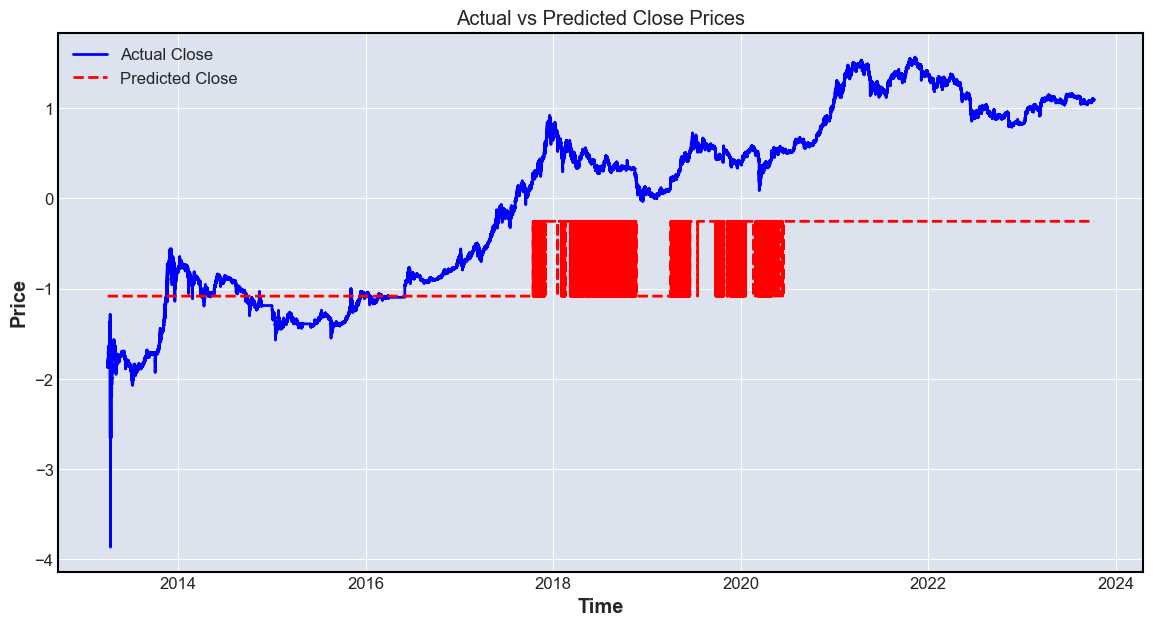

Epoch [2/5], Iteration [1152/34582], Loss: 0.3005
Epoch [2/5], Iteration [2304/34582], Loss: 0.3217
Epoch [2/5], Iteration [3456/34582], Loss: 0.3182
Test Loss: 1.4661
Epoch [2/5], Iteration [4608/34582], Loss: 0.2831
Epoch [2/5], Iteration [5760/34582], Loss: 0.3368
Epoch [2/5], Iteration [6912/34582], Loss: 0.3834
Test Loss: 1.4363
Test Accuracy: 56.28%
Epoch [2/5], Iteration [8064/34582], Loss: 0.3870
Epoch [2/5], Iteration [9216/34582], Loss: 0.2943
Epoch [2/5], Iteration [10368/34582], Loss: 0.2909
Test Loss: 1.4757
Epoch [2/5], Iteration [11520/34582], Loss: 0.2855
Epoch [2/5], Iteration [12672/34582], Loss: 0.3091
Epoch [2/5], Iteration [13824/34582], Loss: 0.3115
Test Loss: 1.4772
Test Accuracy: 56.28%
Epoch [2/5], Iteration [14976/34582], Loss: 0.3514
Epoch [2/5], Iteration [16128/34582], Loss: 0.2633
Epoch [2/5], Iteration [17280/34582], Loss: 0.3002
Test Loss: 1.4613
Epoch [2/5], Iteration [18432/34582], Loss: 0.3111
Epoch [2/5], Iteration [19584/34582], Loss: 0.2786
Epoch [

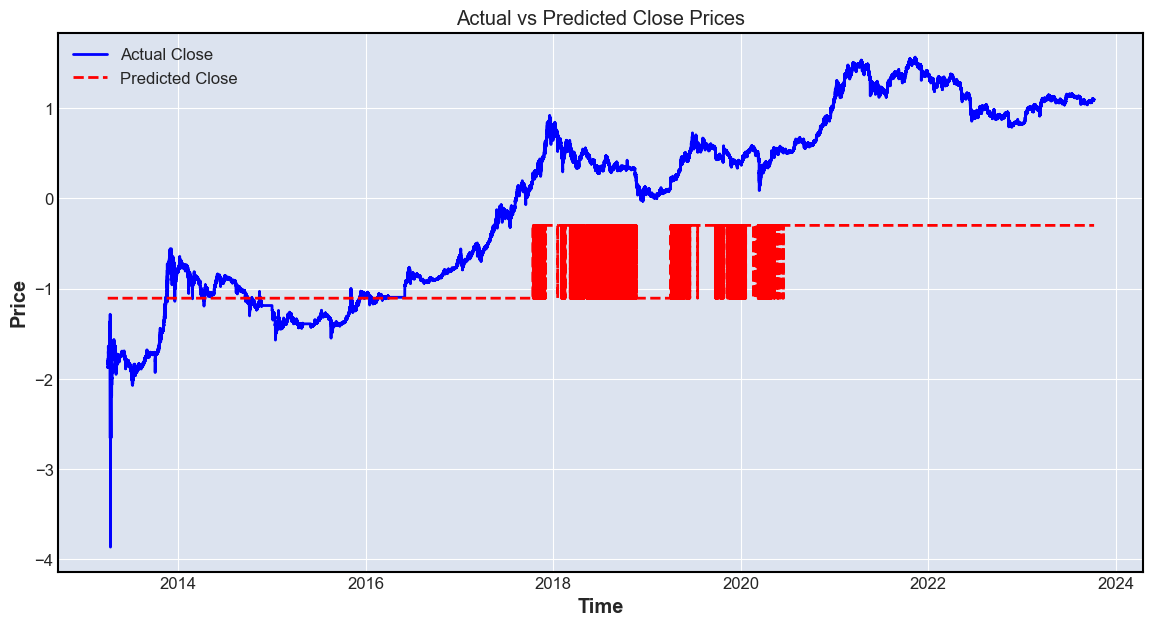

Epoch [3/5], Iteration [1152/34582], Loss: 0.2662
Epoch [3/5], Iteration [2304/34582], Loss: 0.3263
Epoch [3/5], Iteration [3456/34582], Loss: 0.2908
Test Loss: 1.4963
Epoch [3/5], Iteration [4608/34582], Loss: 0.3979
Epoch [3/5], Iteration [5760/34582], Loss: 0.3463
Epoch [3/5], Iteration [6912/34582], Loss: 0.3208
Test Loss: 1.4979
Test Accuracy: 56.28%
Epoch [3/5], Iteration [8064/34582], Loss: 0.3540
Epoch [3/5], Iteration [9216/34582], Loss: 0.3446
Epoch [3/5], Iteration [10368/34582], Loss: 0.3606
Test Loss: 1.5023
Epoch [3/5], Iteration [11520/34582], Loss: 0.2617
Epoch [3/5], Iteration [12672/34582], Loss: 0.3268
Epoch [3/5], Iteration [13824/34582], Loss: 0.3604
Test Loss: 1.5059
Test Accuracy: 56.28%
Epoch [3/5], Iteration [14976/34582], Loss: 0.3332
Epoch [3/5], Iteration [16128/34582], Loss: 0.3101
Epoch [3/5], Iteration [17280/34582], Loss: 0.3678
Test Loss: 1.4873
Epoch [3/5], Iteration [18432/34582], Loss: 0.3237
Epoch [3/5], Iteration [19584/34582], Loss: 0.3491
Epoch [

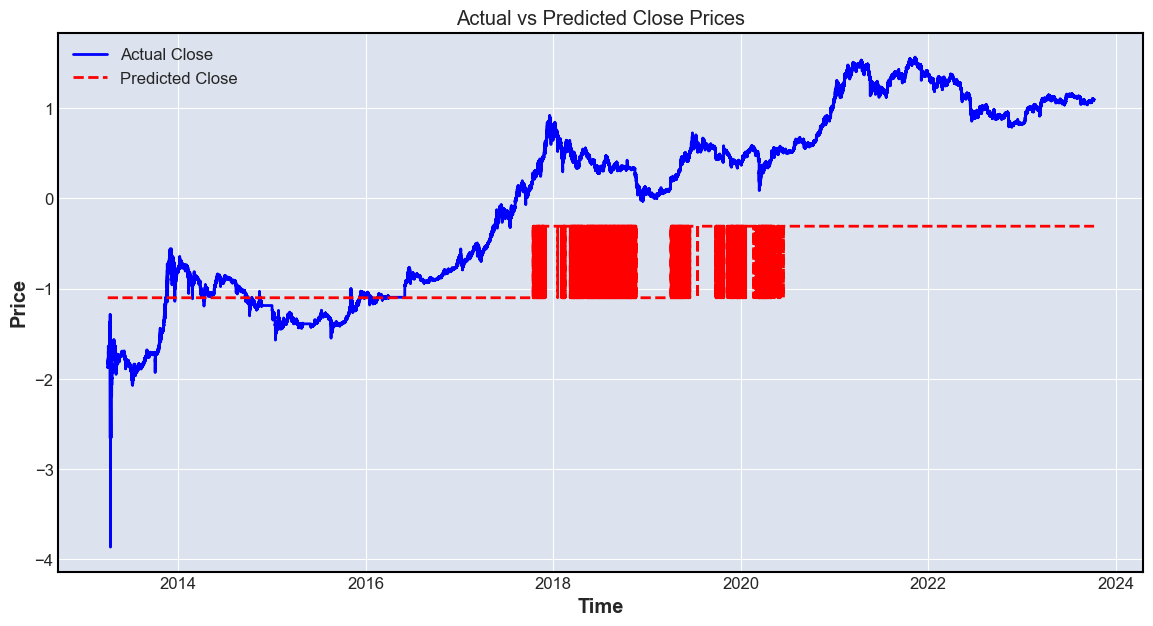

Epoch [4/5], Iteration [1152/34582], Loss: 0.3698
Epoch [4/5], Iteration [2304/34582], Loss: 0.3426
Epoch [4/5], Iteration [3456/34582], Loss: 0.3441
Test Loss: 1.5113
Epoch [4/5], Iteration [4608/34582], Loss: 0.3089
Epoch [4/5], Iteration [5760/34582], Loss: 0.3247
Epoch [4/5], Iteration [6912/34582], Loss: 0.3296
Test Loss: 1.5054
Test Accuracy: 56.28%
Epoch [4/5], Iteration [8064/34582], Loss: 0.2780
Epoch [4/5], Iteration [9216/34582], Loss: 0.3802
Epoch [4/5], Iteration [10368/34582], Loss: 0.3500
Test Loss: 1.5082
Epoch [4/5], Iteration [11520/34582], Loss: 0.2726
Epoch [4/5], Iteration [12672/34582], Loss: 0.3030
Epoch [4/5], Iteration [13824/34582], Loss: 0.3921
Test Loss: 1.4982
Test Accuracy: 56.28%
Epoch [4/5], Iteration [14976/34582], Loss: 0.3716
Epoch [4/5], Iteration [16128/34582], Loss: 0.2847
Epoch [4/5], Iteration [17280/34582], Loss: 0.3043
Test Loss: 1.4933
Epoch [4/5], Iteration [18432/34582], Loss: 0.3325
Epoch [4/5], Iteration [19584/34582], Loss: 0.2341
Epoch [

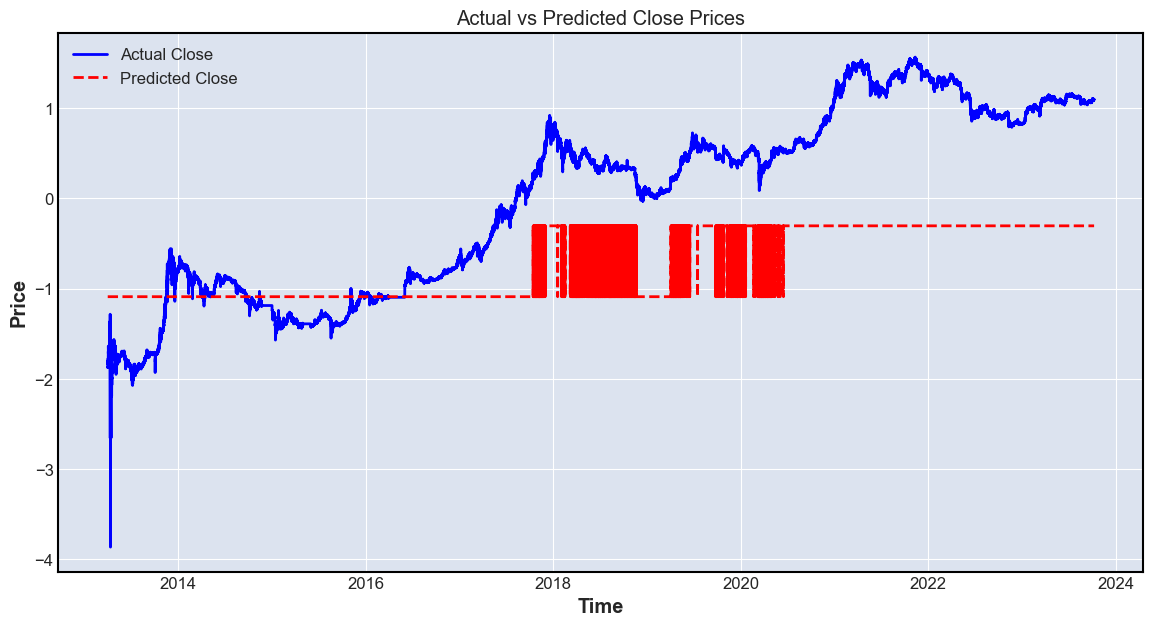

Epoch [5/5], Iteration [1152/34582], Loss: 0.4217
Epoch [5/5], Iteration [2304/34582], Loss: 0.2794
Epoch [5/5], Iteration [3456/34582], Loss: 0.4645
Test Loss: 1.5145
Epoch [5/5], Iteration [4608/34582], Loss: 0.2935
Epoch [5/5], Iteration [5760/34582], Loss: 0.3308
Epoch [5/5], Iteration [6912/34582], Loss: 0.2870
Test Loss: 1.5069
Test Accuracy: 56.28%
Epoch [5/5], Iteration [8064/34582], Loss: 0.3351
Epoch [5/5], Iteration [9216/34582], Loss: 0.3465
Epoch [5/5], Iteration [10368/34582], Loss: 0.4993
Test Loss: 1.4987
Epoch [5/5], Iteration [11520/34582], Loss: 0.3726
Epoch [5/5], Iteration [12672/34582], Loss: 0.3559
Epoch [5/5], Iteration [13824/34582], Loss: 0.3054
Test Loss: 1.5190
Test Accuracy: 56.28%
Epoch [5/5], Iteration [14976/34582], Loss: 0.2853
Epoch [5/5], Iteration [16128/34582], Loss: 0.3397
Epoch [5/5], Iteration [17280/34582], Loss: 0.2858
Test Loss: 1.5193
Epoch [5/5], Iteration [18432/34582], Loss: 0.3013
Epoch [5/5], Iteration [19584/34582], Loss: 0.3862
Epoch [

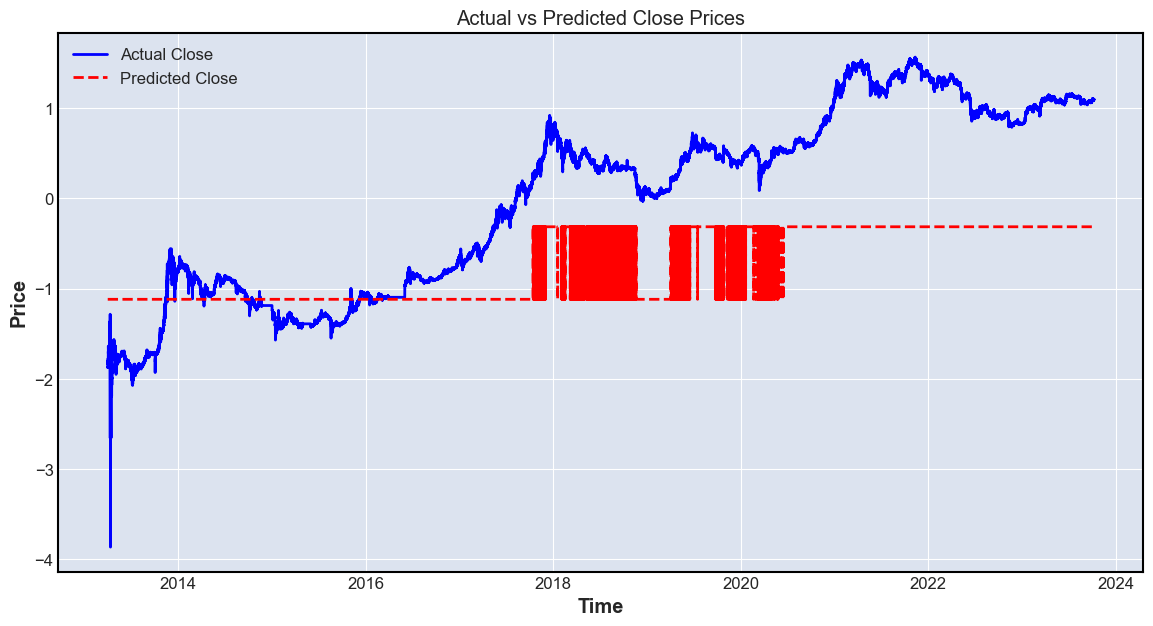

In [7]:
import math
# from torchsummary import summary

hidden_dim = 32
layer_dim = 8
model = LSTMModel(input_dim=5, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=5).to(device)

# summary(model,(seq_length,5))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5

for epoch in range(epochs):
    model.train()
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        y_pred = model(x)
        loss = criterion(y_pred, y)
        
        loss.backward()
        optimizer.step()

        # Print status every 2000 iterations
        if (i + 1) % math.floor(len(train_loader)/30) == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Iteration [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

            if (i+1) % (math.floor(len(train_loader)/30) * 3) == 0:
                # Evaluate on test data
                model.eval()  # Set the model to evaluation mode
                test_loss = 0.0
                test_acc = 0.0  # To accumulate accuracy scores
                total_samples = 0     # To keep track of total samples
                
                with torch.no_grad():  # Disable gradient calculation
                    for x_test, y_test in test_loader:
                        x_test = x_test.to(device)
                        y_test = y_test.to(device)

                        y_test_pred = model(x_test)
                        test_loss += criterion(y_test_pred, y_test).item()

                        if (i+1) % (math.floor(len(train_loader)/30) * 6) == 0:
                            x_test = x_test.cpu().numpy()
    
                            # Assuming the last feature in x_test is 'close'
                            # Adjust the feature index accordingly
                            prev_np = x_test[:, -1, 1]  # Shape: (batch_size,)
    
                            pred_np = y_test_pred.squeeze().cpu().numpy()[:, 1]
                            actual_np = y_test.cpu().numpy()[:,1]
                            
                            # Initialize accuracy for this batch
                            batch_accuracy = 0.0
    
                            for pred, actual, prev in zip(pred_np, actual_np, prev_np):
        
                                # if (actual > prev and pred > prev) or (actual < prev and pred < prev) or (actual == prev and pred == prev):
                                #     batch_accuracy += 1.0
                                # elif (actual != prev and pred == prev) or (actual == prev and pred != prev):
                                #     batch_accuracy += 0.5
                                
                                if (actual > prev and pred > prev) or (actual <= prev and pred <= prev):
                                    batch_accuracy += 1.0
                                else:
                                    batch_accuracy += 0.0
                                
                                total_samples += 1
                                
                            test_acc += batch_accuracy

                test_loss /= len(test_loader)  # Average test loss
                print(f'Test Loss: {test_loss:.4f}')
                if (test_acc != 0):
                    test_acc /=  (total_samples / 100)  # Percentage
                    print(f'Test Accuracy: {test_acc:.2f}%')
                
                model.train()  # Set the model back to training mode
    getPredPlot(model)

In [8]:
# torch.cuda.memory._dump_snapshot("snapshot.pickle")

In [9]:
model.eval()
torch.save({"model_state_dict": model.cpu().state_dict()}, "models/lstm_small.model")